In [65]:
import numpy as np
import os
import sys
sys.path.append('../')
import cv2
from utils import load_datasets
from copy import deepcopy
import sklearn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from keras.api.models import Model
from keras.api.layers import Dense, Conv2D, BatchNormalization, LeakyReLU, Flatten, Softmax, Activation, MaxPool2D, Input, Dropout
from keras.api.optimizers import Adam
from keras.api.losses import binary_crossentropy
from keras.api.utils import to_categorical
import random
import matplotlib.style
import seaborn as sns

In [2]:
def load_train_val(datasets_dir, multi_class=True, new_shape=(270, 460), read_from_stubs=False, stub_path=None, save_stub=False, shuffle=False):
    
    if read_from_stubs and stub_path is not None and len(os.listdir(stub_path)) > 0:
        with open(os.path.join(stub_path, 'ds01_train.npy'), 'rb') as f:
            ds01_train = np.load(f)
        with open(os.path.join(stub_path, 'ds01_val.npy'), 'rb') as f:
            ds01_val = np.load(f)
        with open(os.path.join(stub_path, 'y01_train.npy'), 'rb') as f:
            y01_train = np.load(f)
        with open(os.path.join(stub_path, 'y01_val.npy'), 'rb') as f:
            y01_val = np.load(f)
        
        return ds01_train, y01_train, ds01_val, y01_val 
    
    folders = os.listdir(datasets_dir) if multi_class else os.listdir(datasets_dir)[:4]

    train_total_size = 0
    for folder in folders:
        if folder.endswith('01'):
            train_total_size  += len(os.listdir(os.path.join(datasets_dir, folder)))
    
    ds01_train = np.empty(shape=(int(0.8*train_total_size), new_shape[0], new_shape[1], 3), dtype=np.float32)
    ds01_val = np.empty(shape=(int(0.2*train_total_size), new_shape[0], new_shape[1], 3), dtype=np.float32)
    y01_train = np.empty(shape=(int(0.8*train_total_size), 1))
    y01_val = np.empty(shape=(int(0.2*train_total_size), 1))
    idx_01_train = 0
    idx_01_val = 0
    y01_train_class = 0
    y01_val_class = 0
    
    for folder in folders:
        len_folder = len(os.listdir(os.path.join(datasets_dir, folder)))  
        
        images_path = os.listdir(os.path.join(datasets_dir, folder))
        random.shuffle(images_path)
        if folder.endswith('01'):
            
            for i, file in enumerate(images_path[:int(0.8*len_folder)]):
                ds01_train[i+idx_01_train] = cv2.resize(cv2.imread(os.path.join(datasets_dir, folder, file)) / 255.0, new_shape[::-1])
                y01_train[i+idx_01_train] = y01_train_class
            idx_01_train += int(0.8*len_folder)
            y01_train_class += 1
            
            for i, file in enumerate(images_path[int(0.8*len_folder):]):
                ds01_val[i+idx_01_val] = cv2.resize(cv2.imread(os.path.join(datasets_dir, folder, file)) / 255.0, new_shape[::-1])
                y01_val[i+idx_01_val] = y01_val_class
            idx_01_val += int(0.2*len_folder)
            y01_val_class += 1
    
    if save_stub:
        with open(os.path.join(stub_path, 'ds01_train.npy'), 'wb') as f:
            np.save(f, ds01_train)
        with open(os.path.join(stub_path, 'ds01_val.npy'), 'wb') as f:
            np.save(f, ds01_val)
        with open(os.path.join(stub_path, 'y01_train.npy'), 'wb') as f:
            np.save(f, y01_train)
        with open(os.path.join(stub_path, 'y01_val.npy'), 'wb') as f:
            np.save(f, y01_val)
        
        
    
    if not shuffle:
        return (ds01_train, y01_train), (ds01_val, y01_val)
    else:
        return sklearn.utils.shuffle(ds01_train, y01_train), sklearn.utils.shuffle(ds01_val, y01_val)
    

In [3]:
def load_test(datasets_dir, multi_class=True, new_shape=(270, 460), read_from_stubs=False, stub_path=None, save_stub=False, shuffle=False):
    
    if read_from_stubs and stub_path is not None and len(os.listdir(stub_path)) > 0:
        with open(os.path.join(stub_path, 'ds02.npy'), 'rb') as f:
            ds02 = np.load(f)
        with open(os.path.join(stub_path, 'y02.npy'), 'rb') as f:
            y02 = np.load(f)
        return(ds02, y02)
    
    folders = os.listdir(datasets_dir) if multi_class else os.listdir(datasets_dir)[:4]
    test_total_size = 0
    for folder in folders:
        if folder.endswith('02'):
            test_total_size  += len(os.listdir(os.path.join(datasets_dir, folder)))
    
    ds02 = np.empty(shape=(test_total_size, new_shape[0], new_shape[1], 3), dtype=np.float32)
    y02 = np.empty(shape=(test_total_size, 1))
    
    idx_val = 0
    y02_val_class = 0
    for folder in folders:
        len_folder = len(os.listdir(os.path.join(datasets_dir, folder)))
        if folder.endswith('02'):
            for file in os.listdir(os.path.join(datasets_dir, folder)):
                ds02[idx_val] = cv2.resize(cv2.imread(os.path.join(datasets_dir, folder, file)) / 255.0, new_shape[::-1])
                y02[idx_val] = y02_val_class
                idx_val += 1
            y02_val_class += 1
    
    if save_stub:
        with open(os.path.join(stub_path, 'ds02.npy'), 'wb') as f:
            np.save(f, ds02)
        with open(os.path.join(stub_path, 'y02.npy'), 'wb') as f:
            np.save(f, y02)

    if not shuffle:
        return (ds02, y02)
    else:
        return sklearn.utils.shuffle(ds02, y02)
    

In [4]:
def visualize_data_sample(x, y, random=False):
    if random:
        ind = np.random.permutation(x.shape[0])
        plt.figure(figsize=(20,6))
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(x[ind[i], :, :, ::-1]), plt.title(f'class : {int(y[ind[i]][0])}, ind : {ind[i]}'), plt.axis('off')
    else:
        plt.figure(figsize=(20,6))
        for i in range(9):
            plt.subplot(3,3,i+1)
            plt.imshow(x[i, :, :, ::-1]), plt.title(f'{int(y[i][0])}, ind : {i}'), plt.axis('off')

In [5]:
MULTI_CLASS = False
SHUFFLE = True

In [6]:
(x_train, y_train), (x_val, y_val) = load_train_val(
    datasets_dir='../datasets/Movies',
    multi_class=MULTI_CLASS,
    shuffle=SHUFFLE
)

In [7]:
(x_test, y_test) = load_test(
    datasets_dir='../datasets/Movies',
    multi_class=MULTI_CLASS,
    shuffle=SHUFFLE
)

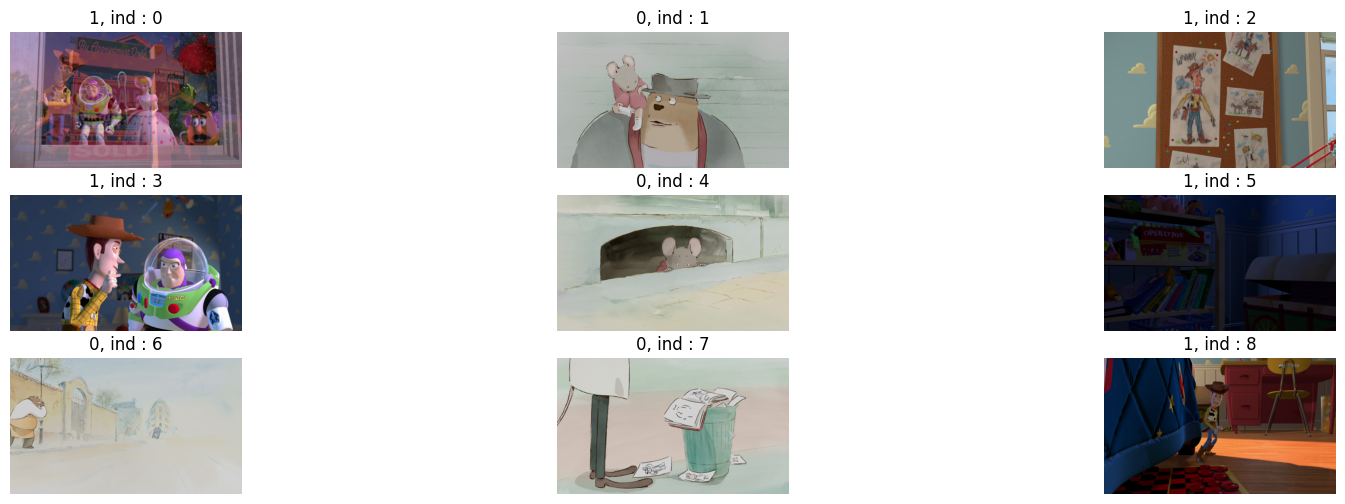

In [8]:
visualize_data_sample(x=x_test, y=y_test)

In [9]:
input = Input((270, 460, 3))

x = Conv2D(filters=16, kernel_size=3, strides=1)(input)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Conv2D(filters=32, kernel_size=3, strides=2)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = MaxPool2D()(x)

x = Flatten()(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate = 0.25)(x)

x = Dense(1)(x)
output = Activation('sigmoid')(x)

model_bin = Model(input, output)

In [10]:
model_bin.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 270, 460, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 268, 458, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 268, 458, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 268, 458, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 134, 229, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 66, 114, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 66, 114, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 66, 114, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 57, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 60192)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,704,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,710,625 (29.41 MB)

 Trainable params: 7,710,273 (29.41 MB)

 Non-trainable params: 352 (1.38 KB)

In [11]:
opt = Adam(learning_rate=0.005)
model_bin.compile(optimizer=opt, loss=binary_crossentropy, metrics=['accuracy'])

In [12]:
history = model_bin.fit(
    x=x_train,
    y=y_train,
    batch_size=16,
    epochs=15,
    validation_data=(x_val, y_val)
)

Epoch 1/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 403ms/step - accuracy: 0.8267 - loss: 0.4763 - val_accuracy: 0.8150 - val_loss: 0.3543
Epoch 2/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.9453 - loss: 0.1528 - val_accuracy: 0.8850 - val_loss: 0.3253
Epoch 3/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.9369 - loss: 0.1439 - val_accuracy: 0.5300 - val_loss: 0.8914
Epoch 4/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.9709 - loss: 0.0994 - val_accuracy: 0.5900 - val_loss: 0.8735
Epoch 5/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.9477 - loss: 0.1158 - val_accuracy: 0.7750 - val_loss: 0.4974
Epoch 6/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.9711 - loss: 0.0632 - val_accuracy: 0.7250 - val_loss: 0.6821
Epoch 7/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.9742 - loss: 0.0664 - val_accuracy: 0.7700 - val_loss: 0.5532
Epoch 8/15
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.9537 - loss: 0.1297 - val_accu

In [13]:
evaluation = model_bin.evaluate(x=x_test, y=y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.8726 - loss: 0.7634


In [77]:
with open('./models/evaluation_bin.npy', 'wb') as f:
    np.save(f, evaluation)

In [21]:
model_bin.save('./models/model_bin.keras')

In [59]:
plt.style.use('default')

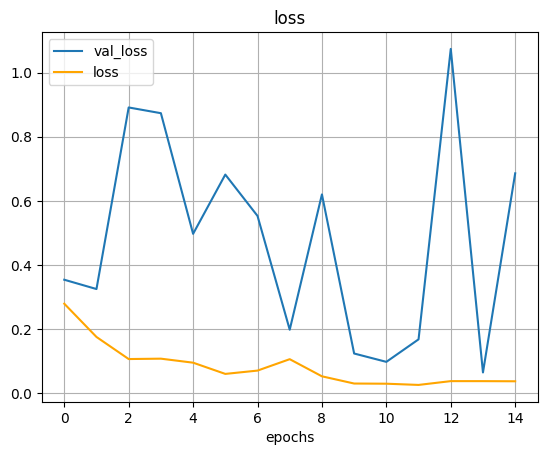

In [60]:
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss', color='orange')
plt.xlabel('epochs')
plt.legend()
plt.title('loss')
plt.grid(True)

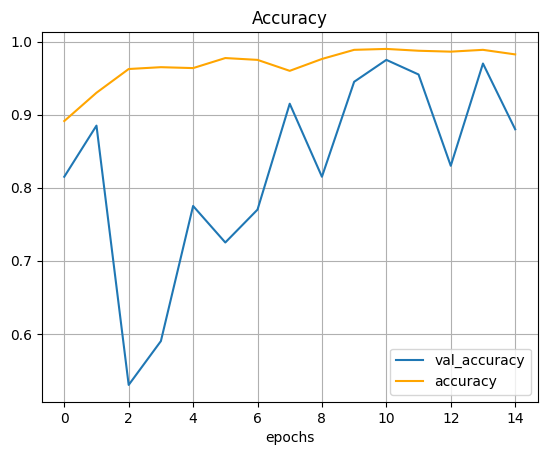

In [62]:
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy', color='orange')
plt.xlabel('epochs')
plt.legend()
plt.title('Accuracy')
plt.grid(True)

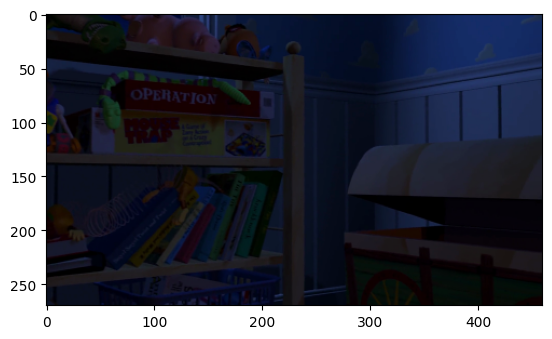

In [63]:
plt.imshow(x_test[5,:,:,::-1])

In [47]:
y_pred  = (model_bin.predict(x_test) >= 0.5).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step


In [57]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

Text(50.722222222222214, 0.5, 'True classes')

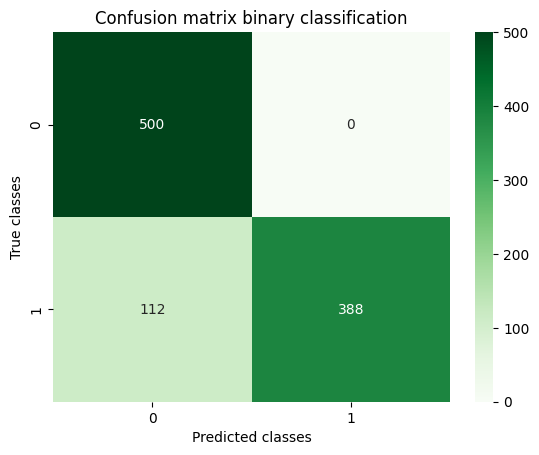

In [75]:
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens'), plt.title('Confusion matrix binary classification')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')

In [50]:
matplotlib.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']